In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import os
print(os.getcwd())

/home/mingxuan/Repositories/scg_tsung/examples/rl


In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, mode='valid')
    
def load_from_log_file(path):
    '''Return x, y sequence data from the stat csv.'''
    with open(path, 'r') as f:
        lines = f.readlines()
    # Labels.
    xk, yk = [k.strip() for k in lines[0].strip().split(',')]
    # Values.
    x, y = [], []
    for line in lines[1:]:
        data = line.strip().split(',')
        x.append(float(data[0].strip()))
        y.append(float(data[1].strip()))
    x = np.array(x)
    y = np.array(y)
    return xk, x, yk, y

In [4]:
# colors = {
#     "ref": "black",
#     "PPO": "tab:orange",
#     "PPO2": "tab:red",
#     "PPO3": "tab:olive",
#     "PPO4": "tab:cyan",
#     "SAC": "tab:green",
#     "TD3": "tab:cyan",
#     "GP-MPC": "tab:blue",
#     "iLQR": "slateblue",
#     'LQR': 'blueviolet',
#     "Linear MPC": "tab:brown",
#     "MPC": "tab:purple",
#     'PID': 'tab:gray',
# }

colors = {
    "ref": "black",
    "PPO": "darkorange",
    "SAC": "red",
    "TD3": "tab:cyan",
    "DPPO": "pink",
    "GP-MPC": "royalblue",
    "iLQR": "slateblue",
    'LQR': 'blueviolet',
    "Linear MPC": "green",
    "MPC": "aqua",
    "F-MPC": "darkblue",
    'PID': 'tab:gray',
}
plot_colors = {
    'GP-MPC': 'royalblue',
    'PPO': 'darkorange',
    'SAC': 'red',
    'DPPO': 'pink',
    'iLQR': 'darkgray',
    'Linear MPC': 'green',
    'Nonlinear MPC': 'cadetblue',
    "PID": "tab:gray",
    "iLQR": "slateblue",
    'LQR': 'blueviolet',
    "F-MPC": "darkblue",
    'MAX': 'none',
    'MIN': 'none',
}

ref_color = 'black'

gpmpc_color = 'royalblue'
gpmpc_hull_color = 'cornflowerblue'
lmpc_color = 'green'
lmpc_hull_color = 'lightgreen'
mpc_color = 'aqua'
mpc_hull_color = 'paleturquoise'

ppo_color = 'darkorange'
ppo_hull_color = 'moccasin'
sac_color = 'red'
sac_hull_color = 'salmon'
td3_color = 'pink'
td3_hull_color = 'lavenderblush'



legends = {
    "ref": "black",
    "PPO": "PPO",
    "PPO3": "PPO with ilqr ref",
    "PPO4": "PPO with ilqr state ref",
    "SAC": "SAC",
    "TD3": "TD3",
    "DPPO": "DPPO",
    "GP-MPC": "GP-MPC",
    "F-MPC": "F-MPC",
}

In [5]:
seeds = [i for i in range(0,5)]

data_paths = {
            # "PPO": "/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_ppo_data8/",
            # "PPO": "/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_ppo_data4/",
            "SAC": "/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_sac_data2/",
            # "DPPO": "/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_dppo_data8/",
            # "DPPO": "/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_dppo_data6/",
            "PPO": "/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_ppo_data4/",
            "DPPO": "/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_dppo_data2/",
}

### Convergence plot

In [6]:
# perf_data = {}
# for method in data_paths.keys():
#     print(method)
#     perf_data.update({method: {}})
#     for seed in seeds:
#         # print(data_paths[method] + str(seed) + "/logs/stat_eval/ep_length.log")
#         xk, x, lk, l = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_length.log")
#         xk, x, yk, y = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return.log")
#         xk, x, zk, z = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return_std.log")
#         # xk, x, ck, c = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/constraint_violation.log")
#         # perf_data[method].update({seed: {"x": x, "y": y, "c": c}})
#         # perf_data[method].update({seed: {"x": x, "y": y, "z": z, "c": c}})
#         xk, x, yk, m = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/rmse.log")
#         xk, x, yk, n = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/rmse_std.log")
#         # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
#         perf_data[method].update({seed: {"x": x, "y": y, "z": z, "m": m, "n": n, "l": l}})

perf_data = {}
for method in data_paths.keys():
    print(method)
    perf_data.update({method: {}})
    temp = [x for x in os.listdir(data_paths[method])]
    for sd in os.listdir(data_paths[method]):
        seed = sd[4]
        xk, x, lk, l = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/ep_length.log")
        xk, x, yk, y = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/ep_return_std.log")
        # xk, x, ck, c = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/constraint_violation.log")
        # perf_data[method].update({seed: {"x": x, "y": y, "c": c}})
        # perf_data[method].update({seed: {"x": x, "y": y, "z": z, "c": c}})
        xk, x, yk, m = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/rmse.log")
        xk, x, yk, n = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/rmse_std.log")
        # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
        perf_data[method].update({int(seed): {"data": x, "ep_return": y, "ep_return_std": z, "rmse": m, "rmse_std": n, "ep_length": l}})

SAC
PPO
DPPO


In [7]:
perf_data["PPO"][0].keys()

dict_keys(['data', 'ep_return', 'ep_return_std', 'rmse', 'rmse_std', 'ep_length'])

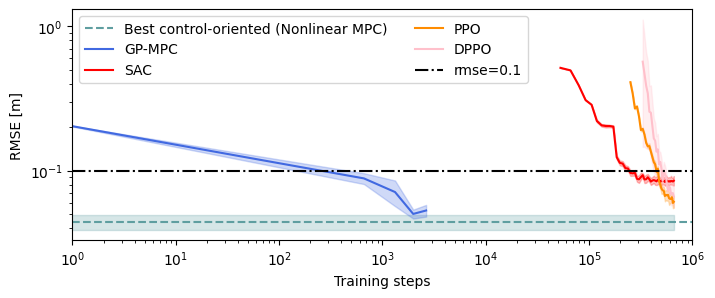

In [12]:
eval_data = {}
w = 1
fig = plt.figure(figsize=(8, 3)) 
mean_fn = np.percentile
perc = 90
n_seeds = 10
last_iter = perf_data["PPO"][0]["data"][-1]
seeds = [i for i in range(0, n_seeds)]
# last_iter = 3e5

# # PID
# p1 = 0.08250423980732591
# p2 = 0.004362996364150534
# plt.axhline(xmin=0.0, xmax=1.95, y=p1, linestyle='--', color=plot_colors["PID"], label='PID')
# plt.fill_between([0.0, last_iter], p1-w*p2, p1+w*p2, color=plot_colors["PID"], alpha=0.25)

# # LQR
# p1 = 0.1294216883185255
# p2 = 0.0024129703900749554
# plt.axhline(xmin=0.0, xmax=1.95, y=p1, linestyle='--', color=plot_colors["LQR"], label='LQR')
# plt.fill_between([0.0, last_iter], p1-w*p2, p1+w*p2, color=plot_colors["LQR"], alpha=0.25)

# # iLQR
# p1 = 0.051255378658864446
# p2 = 0.005692145991744724
# plt.axhline(xmin=0.0, xmax=1.95, y=p1, linestyle='--', color=plot_colors["iLQR"], label='iLQR')
# plt.fill_between([0.0, last_iter], p1-w*p2, p1+w*p2, color=plot_colors["iLQR"], alpha=0.25)

# Linear MPC
# p1 = 0.06556989411791102
# p2 = 0.0035402446045955343
# plt.axhline(xmin=0.0, xmax=1.95, y=p1, linestyle='--', color=plot_colors["Linear MPC"], label='Linear MPC')
# plt.fill_between([0.0, last_iter], p1-w*p2, p1+w*p2, color=plot_colors["Linear MPC"], alpha=0.25)

# Nonlinear MPC
p1 = 0.04421752503119518
p2 = 0.005051390779798208
plt.axhline(xmin=0.0, xmax=1.95, y=p1, linestyle='--', color=plot_colors["Nonlinear MPC"], label='Best control-oriented (Nonlinear MPC)')
plt.fill_between([0.0, last_iter], p1-w*p2, p1+w*p2, color=plot_colors["Nonlinear MPC"], alpha=0.25)

# # F-MPC
# p1 = 0.05599325343755744
# p2 = 0.004517153272013717
# plt.axhline(xmin=0.0, xmax=1.95, y=p1, linestyle='--', color=plot_colors["F-MPC"], label='F-MPC')
# plt.fill_between([0.0, last_iter], p1-w*p2, p1+w*p2, color=plot_colors["F-MPC"], alpha=0.25)

gp_mpc_data = np.load("/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/gpmpc.npy", allow_pickle=True).item()
# start_iter = last_iter - gp_mpc_data['train_steps'][-1]
plt.plot(gp_mpc_data['train_steps']+1, mean_fn(gp_mpc_data['rmse'], perc, axis=0), color=plot_colors["GP-MPC"], label='GP-MPC')
plt.fill_between(gp_mpc_data['train_steps']+1, 
                 np.clip(mean_fn(gp_mpc_data['rmse'], perc, axis=0)-w*gp_mpc_data['rmse'].std(axis=0), 0, 10), 
                 np.clip(mean_fn(gp_mpc_data['rmse'], perc, axis=0)+w*gp_mpc_data['rmse'].std(axis=0), 0, 10), 
                 color=plot_colors["GP-MPC"], alpha=0.25)

# start_iter = last_iter - gp_mpc_data['train_steps'][-1]
for t, method in enumerate(data_paths.keys()):
    temp = np.zeros((n_seeds, 6, perf_data[method][seeds[0]]["data"].shape[0]))
    for seed in seeds:
        temp[seed, 0, :] = perf_data[method][seed]["data"]
        temp[seed, 1, :] = perf_data[method][seed]["ep_return"]
        temp[seed, 2, :] = perf_data[method][seed]["ep_return_std"]
        temp[seed, 3, :] = perf_data[method][seed]["rmse"]
        temp[seed, 4, :] = perf_data[method][seed]["rmse_std"]
        temp[seed, 5, :] = perf_data[method][seed]["ep_length"]
    j_max = 0
    for seed in seeds:
        for j,k in enumerate(temp[seed, 0, :]):
            if temp[seed, 5, j] < 660:
                temp[seed, 1, j] = np.nan
                temp[seed, 2, j] = np.nan
                temp[seed, 3, j] = np.nan
                temp[seed, 4, j] = np.nan
                if j >= j_max:
                    j_max = j+1
    eval_data.update({method: temp})

    plt.plot(temp[0,0,:], mean_fn(temp[:,3,:], perc, axis=0), color=plot_colors[method], label=legends[method])
    plt.fill_between(temp[0,0,:], 
                     0.0+np.clip(mean_fn(temp[:,3,:]-temp[:,4,:], perc, axis=0), 0, 10),  
                     0.0+np.clip(mean_fn(temp[:,3,:]+temp[:,4,:], perc, axis=0), 0, 10), color=plot_colors[method], alpha=0.25)
# s = 1 # time std
# rmse_ilqr_mean = 0.026000000000000002 * 0
# rmse_ilqr_std = 0.001843908891458577 * 0
plt.axhline(xmin=0.0, xmax=1.95, y=0.1, linestyle='-.', color='k', label='rmse=0.1')
# plt.fill_between([0.0, last_iter], rmse_ilqr_mean-s*rmse_ilqr_std, rmse_ilqr_mean+s*rmse_ilqr_std, color=colors["iLQR"], alpha=0.25)

# real experiment data
# plt.plot(last_iter, 0.086, color=colors['PPO'], marker='x')
# plt.plot(last_iter, 0.064, color=colors['SAC'], marker='x')

plt.legend(ncol=2, loc='upper left')
# plt.xlim(-10000, 460000)
# plt.xlim(1,20000)
plt.xlim(1, 1e6)
log_x = True
# log_x = False
log_y = True
# log_y = False
plt.xscale("log") if log_x else None
plt.yscale("log") if log_y else None
# plt.text(900, 0.3, "Unssucessful evaluation runs", bbox=dict(facecolor='red', alpha=0.25))
# plt.xlabel("Training steps [s]")
plt.xlabel("Training steps")
plt.ylabel("RMSE [m]")
#plt.title("Task: Quadrotor 2D")
if log_x and log_y:
    plt.savefig("performance_logxy.pdf",bbox_inches="tight", pad_inches=0.1)
elif log_x:
    plt.savefig("performance_logx.pdf",bbox_inches="tight", pad_inches=0.1)
else:
    plt.savefig("performance_linearx.pdf",bbox_inches="tight", pad_inches=0.1)

plt.savefig("performance_logxy_best_mb_step.pdf",bbox_inches="tight", pad_inches=0.1)

### Performance metric

In [13]:
perf_metric = {}
for method in data_paths.keys():
    print(method)
    perf_metric.update({method: {'rmse': [], 'rmse_std': [], 'success': []}})
    # for seed in seeds:
    for seed in [0]:
        temp = np.load(data_paths[method] + str(seed) +"/perf_metric.npy", allow_pickle=True).item()
        perf_metric[method]['rmse'].append(temp['rmse'])
        perf_metric[method]['rmse_std'].append(temp['rmse_std'])
        temp2 = True if temp['average_length'] == 660.0 else False
        perf_metric[method]['success'].append(temp2)
print(f"Performance of PPO is {np.array(perf_metric['PPO']['rmse']).mean()} +/- {np.array(perf_metric['PPO']['rmse']).std()}")
print(f"Performance of SAC is {np.array(perf_metric['SAC']['rmse']).mean()} +/- {np.array(perf_metric['SAC']['rmse']).std()}")
# print(f"Performance of TD3 is {np.array(perf_metric['TD3']['rmse']).mean()} +/- {np.array(perf_metric['TD3']['rmse']).std()}")
print(f"Performance of DPPO is {np.array(perf_metric['DPPO']['rmse']).mean()} +/- {np.array(perf_metric['DPPO']['rmse']).std()}")

SAC


FileNotFoundError: [Errno 2] No such file or directory: '/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_sac_data2/0/perf_metric.npy'

### Generalization metric

In [14]:
transfer_metric = {}
for method in data_paths.keys():
    print(method)
    transfer_metric.update({method: {'rmse': [], 'rmse_std': [], 'success': []}})
    # for seed in seeds:
    for seed in [0]:
        temp = np.load(data_paths[method] + str(seed) +"/transfer_metric_11.npy", allow_pickle=True).item()
        transfer_metric[method]['rmse'].append(temp['rmse'])
        transfer_metric[method]['rmse_std'].append(temp['rmse_std'])
        temp2 = True if temp['average_length'] == 540.0 else False
        transfer_metric[method]['success'].append(temp2)
print(f"Performance of PPO is {np.array(transfer_metric['PPO']['rmse']).mean()} +/- {np.array(transfer_metric['PPO']['rmse']).std()}")
print(f"Performance of SAC is {np.array(transfer_metric['SAC']['rmse']).mean()} +/- {np.array(transfer_metric['SAC']['rmse']).std()}")
# print(f"Performance of TD3 is {np.array(transfer_metric['TD3']['rmse']).mean()} +/- {np.array(transfer_metric['TD3']['rmse']).std()}")
print(f"Performance of DPPO is {np.array(transfer_metric['DPPO']['rmse']).mean()} +/- {np.array(transfer_metric['DPPO']['rmse']).std()}")

SAC


FileNotFoundError: [Errno 2] No such file or directory: '/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_sac_data2/0/transfer_metric_11.npy'

In [15]:
episode_len_list = [9, 10, 11, 12, 13, 14, 15]
transfer_metric = {}
for method in data_paths.keys():
    print(method)
    transfer_metric.update({method: {'rmse': [], 'rmse_std': []}})
    for T in episode_len_list:
        rmse, rmse_std = [], []
        # for seed in seeds:
        for seed in [0]:
            temp = np.load(data_paths[method] + str(seed) +"/transfer_metric_"+str(T)+".npy", allow_pickle=True).item()
            rmse.append(temp['rmse'])
            rmse_std.append(temp['rmse_std'])
        transfer_metric[method]['rmse'].append(np.array(rmse).mean())
        transfer_metric[method]['rmse_std'].append(np.array(rmse_std).mean())
    transfer_metric[method]['rmse'] = np.array(transfer_metric[method]['rmse'])
    transfer_metric[method]['rmse_std'] = np.array(transfer_metric[method]['rmse_std'])


SAC


FileNotFoundError: [Errno 2] No such file or directory: '/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_sac_data2/0/transfer_metric_9.npy'

In [19]:
episode_period_list =  [episode_len_list[i]/2 for i in range(len(episode_len_list))]
episode_period_list

[4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5]

In [ ]:
# transfer_metric['PPO']['rmse'][1] = 0.01746153113470009
# transfer_metric['DPPO']['rmse'][1] = 0.01931011838369746

In [20]:
transfer_metric['PPO'] = {'rmse': np.array([0.1368606, 
                                            0.0816077 , 
                                            0.05377189, 
                                            0.06403641, 
                                            0.08557263,
                                            0.1092245 , 
                                            0.13115713]),
  'rmse_std': np.array([0.00831348, 
                        0.00629567, 
                        0.00578461, 
                        0.00475708, 
                        0.00439944,
                        0.00333712, 
                        0.00348482])}

transfer_metric['SAC'] = {'rmse': np.array([0.13443702, 0.09492134, 0.07645108, 0.07570821, 0.08217785,
         0.09167647, 0.10112919]),
  'rmse_std': np.array([0.0081641 , 0.00601878, 0.00545505, 0.00515048, 0.00349724,
         0.00285453, 0.00200984])}

transfer_metric['DPPO'] = {'rmse': np.array([0.16563129, 0.09192322, 0.05619716, 0.07451258, 0.10576372,
         0.13815606, 0.16684679]),
  'rmse_std': np.array([0.00991649, 0.00571679, 0.00544798, 0.00455611, 0.0044244 ,
         0.00289066, 0.00279866])}

transfer_metric['GP-MPC'] = {'rmse': np.array([0.07240253210609013, 
                                               0.06001951283653607,
                                              0.049872511450839645,
                                               0.043216195868052004,
                                               0.03819312862247324,
                                               0.03440810993189095,
                                              0.031425261835490235]), 
                             'rmse_std': np.array([0.005935227930378862,
                                                   0.005650813796205759,
                                                  0.005132586426383544,
                                                   0.005048544039303885,
                                                   0.004922580428116054,
                                                   0.004879404518445507,
                                                  0.004910546198568348])}
transfer_metric['Nonlinear MPC'] = {'rmse': np.array([0.06669989755434953,
                                            0.053871034117811606,
                                                  0.04421752503119518,
                                            0.03683269097948807,
                                            0.030699167806897958,
                                            0.026301931256398743,
                                                  0.023313325828377546]), 
                                 'rmse_std': np.array([0.0059149924488957496,
                                                       0.005462706718375091,
                                                      0.005051390779798208,
                                                       0.004678658729904046,
                                                       0.004937412985172684,
                                                       0.004577798254254554,
                                                      0.0059149924488957496])}
transfer_metric['Linear MPC'] = {'rmse': np.array([0.09475888182425916,
                                                   0.07615922745804085,
                                                   0.06284182159429033,
                                                   0.05269199795374748,
                                                   0.04495251910240445,
                                                   0.03897086184501473,
                                                   0.034306490036127714]), 
                                 'rmse_std': np.array([0.007239342361923242,
                                                       0.006465336668020594,
                                               0.005862348764648783,
                                                       0.005396791354531926,
                                                       0.004953459868638366,
                                                       0.004571229275822178,
                                               0.0042428141668883965])}

transfer_metric['PID'] = {'rmse': np.array([
                0.1267140407891643 ,
                0.0988097846017361 ,
                0.08278469633434819,
                0.07065035075584047,
                0.06127201471602434,
                0.05395643208113244,
                0.04824230553227972,]),
                                'rmse_std': np.array([
0.0029511098006500427,
0.0030682172860547856,
 0.0028022361183366964,
 0.002614698070973941,
 0.0024000624707497162,
 0.0022286776516758735,
 0.002091380975265172,])}


transfer_metric['iLQR'] = {
    'rmse': np.array(
        [
0.21703079983074353,
0.06156441022431045,
0.0492655107844662,
0.04704166954327524,
0.04575977615323228,
0.04585821841806553,
0.044875452075620124,
        ]
    ),
    'rmse_std': np.array(
        [
0.005448458899934409,
0.006604899731733592,
0.0060723010437989606,
0.020855273749185665,
0.023371886071269277,
0.021932124002619596,
0.01965094895126218,
]
    )
}

transfer_metric['LQR'] = {
    'rmse': np.array(
        [
0.2213938285487961, 
0.15709445089558244, 
0.12846739566058812, 
0.10732456008838964, 
0.09114763208143276, 
0.07852184934755621, 
0.06844943242219405, 
        ]
    ),
    'rmse_std': np.array(
        [ 
0.005423289536313686,
0.0026995297373064247,
0.002504727967472569,
0.00242479898835931,
0.0023093985687539127,
0.002218939865620277,
0.0021388635097284534,
]
    )
}
# fmpc
transfer_metric['F-MPC'] = {
    'rmse': np.array(
[0.07809048366149708, 
0.06560017104256753, 
0.05599325343755744, 
0.04862759252089173, 
0.04288760919776039, 
0.038308710707202855, 
0.03448930158456177,]
    ),
    'rmse_std': np.array(
[0.005388320404773807,
0.004956623756237586,
0.004517153272013717,
0.004077679514643914,
0.0037744226562102827,
0.003626600561862868,
0.0034758918530048903,
        ])
}


In [17]:
type(transfer_metric['PPO'])
# type(transfer_metric['PID'])

dict

PPO
SAC
DPPO


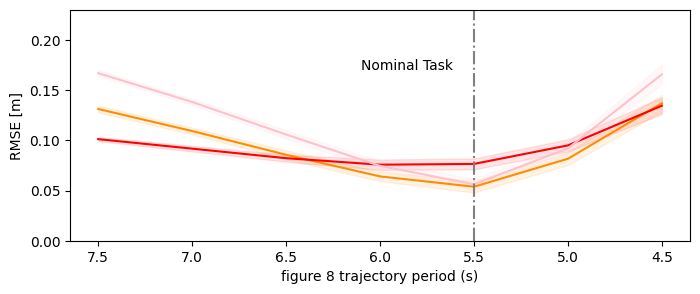

In [ ]:
fig = plt.figure(figsize=(8, 3))
plot_list = [
    'PPO', 'SAC', 'DPPO',
    # 'PPO', 'DPPO',
    'Linear MPC', 'Nonlinear MPC', 'GP-MPC', 'F-MPC',
    'PID', 'iLQR', 'LQR'
]
for method in plot_list:
    print(method)
    # if method == 'DPPO':
    #     plt.plot(episode_period_list, transfer_metric[method]['rmse'], label=method, linestyle='--', color=plot_colors[method])
    #     plt.fill_between(episode_period_list, 
    #                  transfer_metric[method]['rmse']-transfer_metric[method]['rmse_std'],  
    #                  transfer_metric[method]['rmse']+transfer_metric[method]['rmse_std'], color=plot_colors[method], alpha=0.1)
    # else:
    plt.plot(episode_period_list, transfer_metric[method]['rmse'], label=method, color=plot_colors[method])
    plt.fill_between(episode_period_list, 
                        transfer_metric[method]['rmse']-transfer_metric[method]['rmse_std'],  
                        transfer_metric[method]['rmse']+transfer_metric[method]['rmse_std'], color=plot_colors[method], alpha=0.1)
plt.axvline(x=5.5, linestyle='-.', color='gray')
plt.text(6.1, 0.17, 'Nominal Task')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,0.23)
#plt.xlim(0,50)
plt.gca().invert_xaxis()
plt.xlabel("figure 8 trajectory period (s)")
plt.ylabel("RMSE [m]")
plt.savefig("generalization_curve.pdf",bbox_inches="tight", pad_inches=0.1)

In [ ]:
transfer_metric

{'SAC': {'rmse': array([0.13622967, 0.0919773 , 0.07543519, 0.07440527, 0.07919276,
         0.08650219, 0.0933615 ]),
  'rmse_std': array([0.00743797, 0.00615574, 0.00530551, 0.00471688, 0.00320375,
         0.00265086, 0.00183872])},
 'PPO': {'rmse': array([0.09449988, 0.05368947, 0.03875599, 0.0488293 , 0.06631944,
         0.08358926, 0.09940848]),
  'rmse_std': array([0.00544533, 0.00632373, 0.00611874, 0.00360708, 0.00204613,
         0.00129849, 0.00094998])},
 'DPPO': {'rmse': array([0.08832988, 0.05370586, 0.03779299, 0.04385754, 0.05918833,
         0.07495349, 0.08935109]),
  'rmse_std': array([0.00491171, 0.0064562 , 0.00757604, 0.00577639, 0.00389619,
         0.00276347, 0.00206257])},
 'GP-MPC': {'rmse': array([0.07240253, 0.06001951, 0.04987251, 0.0432162 , 0.03819313,
         0.03440811, 0.03142526]),
  'rmse_std': array([0.00593523, 0.00565081, 0.00513259, 0.00504854, 0.00492258,
         0.0048794 , 0.00491055])},
 'Nonlinear MPC': {'rmse': array([0.0666999 , 0.0538

### Robustness metric

In [25]:
metric = {}
noise_scale = [0,1,10,20,30,40,50,60,70,80,90,100]
noise_scale2 = [0,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
for method in data_paths.keys():
    print(method)
    metric.update({method: {}})
    for seed in seeds:
        for ns in noise_scale:
            temp = np.load(data_paths[method] + str(seed) +"/robust_metric_"+str(ns)+".npy", allow_pickle=True).item()
            if ns in metric[method].keys():
                metric[method][ns]['rmse'].append(temp['rmse'])
                metric[method][ns]['rmse_std'].append(temp['rmse_std'])
                temp2 = True if temp['average_length'] >= 660.0 else False
                metric[method][ns]['success'].append(temp2)
            else:
                temp2 = True if temp['average_length'] >= 660.0 else False
                metric[method].update({ns: {'rmse': [temp['rmse']], 
                                            'rmse_std': [temp['rmse_std']], 
                                            'success': [temp2]}})

SAC


FileNotFoundError: [Errno 2] No such file or directory: '/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/quadrotor_2D_attitude_sac_data2/0/robust_metric_0.npy'

In [ ]:
#np.save('compiled_metric.npy',metric, allow_pickle=True)

In [ ]:
fig = plt.figure(figsize=(8, 3))
for method in metric.keys():
    print(method)
    temp, temp_std1, temp_std2 = [], [], []
    traj_success_till = 200
    count = 0
    for k, ns in enumerate(noise_scale):
        data = np.array(metric[method][ns]['rmse'])
        temp.append(data.mean())
        temp_std1.append(data.mean() - 1*data.std())
        temp_std2.append(data.mean() + 1*data.std())
        # print(all(metric[method][ns]['success']))
        if not all(metric[method][ns]['success']) and traj_success_till > ns:
            traj_success_till = ns
            count = k
    temp = np.array(temp)
    temp_std1, temp_std2 = np.array(temp_std1), np.array(temp_std2)
    print(traj_success_till)
    
    
    plt.plot(noise_scale[:count+1], temp[:count+1]*100/temp[0], color=plot_colors[method], label=method)
    plt.axvline(x=traj_success_till, linestyle='-.', linewidth=0.5, color=plot_colors[method])
    plt.plot(noise_scale[count:], temp[count:]*100/temp[0], color=plot_colors[method], linestyle='--')
    plt.fill_between(noise_scale, 
                     temp_std1*100/temp[0],  
                     temp_std2*100/temp[0], color=plot_colors[method], alpha=0.1)
    
    #plt.fill_between([traj_success_till, 100], [1, 1], color='r', alpha=0.25, label=method)

plt.plot(noise_scale2, [100]*len(noise_scale2), color='grey', linestyle='-.', label='Relative Perf=100%')
plt.text(11, 2500, 'PPO \nearly stop')
plt.text(31, 800, 'SAC \nearly stop')
plt.text(21, 1500, 'DPPO \nearly stop')


plt.legend()
plt.ylim(0,3000)
plt.xlim(0,150)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
plt.xlabel("Noise Scale")
plt.ylabel("Relative Performance %")
#plt.title("TD3 for Quadrotor 2D")
plt.savefig("robustness_rl.pdf",bbox_inches="tight", pad_inches=0.1)

PPO


KeyError: 0

<Figure size 800x300 with 0 Axes>

In [ ]:
linear_mpc_data = np.load('/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/noise_results_linear_mpc_acados.npy', allow_pickle=True).item()
mpc_data = np.load('/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/noise_results_mpc_acados.npy', allow_pickle=True).item()
gpmpc_data = np.load('/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/noise_results_gpmpc_acados.npy', allow_pickle=True).item()
ilqr_data = np.load('/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/noise_results_ilqr.npy', allow_pickle=True).item()
lqr_data = np.load('/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/noise_results_lqr.npy', allow_pickle=True).item()
pid_data = np.load('/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/noise_results_pid.npy', allow_pickle=True).item()
fmpc_data = np.load('/home/mingxuan/Repositories/scg_tsung/benchmarking_sim/quadrotor/data/noise_results_fmpc.npy', allow_pickle=True).item()

noise_data = {'Linear MPC': linear_mpc_data, 
              'Nonlinear MPC': mpc_data, 
              'GP-MPC': gpmpc_data,
              'iLQR': ilqr_data,
              'LQR': lqr_data,
              'PID': pid_data,
              'F-MPC': fmpc_data,
              } 
noise_scale = [0,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

# linear_mpc_data.keys()
# mpc_data.keys()
# gpmpc_data.keys()
# for i in range(1, len(mpc_data.keys())):
#     print(f'key {i}, ')
#     print(len(mpc_data[repr(i)]['rmse']))

# # delete 4th and 5th key and the data in the dic
# mpc_data.pop(repr(5))
# mpc_data.pop(repr(6))

# print('')
# for key in mpc_data.keys():
#     print(len(mpc_data[key]['rmse']))

Linear MPC: 110.0
Nonlinear MPC: 91.0
GP-MPC: 121.0
iLQR: 41.0
LQR: 101.0
PID: 111.0
F-MPC: 110.0


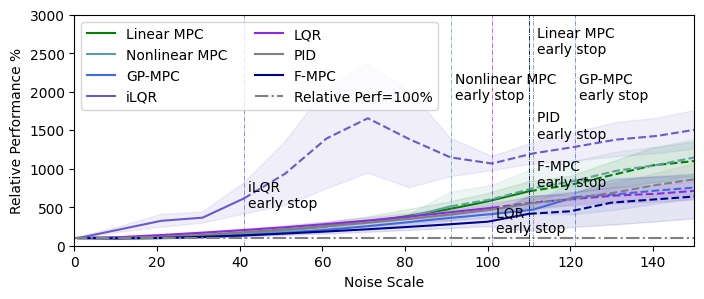

In [ ]:
fig = plt.figure(figsize=(8, 3))
for method in noise_data.keys():
    temp1, temp2, temp3 = [], [], []
    for seed_str in noise_data[method]:
        temp1.append(noise_data[method][seed_str]['rmse'])
        temp2.append(noise_data[method][seed_str]['early_stop'])
        temp3.append(noise_data[method][seed_str]['noise_factor'])
    # for i in range(len(temp1)):
    #     print(len(temp1[i]))
    #     print(len(temp1[i]))
    temp1 = np.array(temp1)
    temp2, temp3 = np.array(temp2).mean(axis=0), np.array(temp3).mean(axis=0)

    traj_success_till = 200
    count = 20
    temp, temp_std1, temp_std2 = [], [], []
    for k, ns in enumerate(temp3):
        temp.append(temp1[:, k].mean())
        temp_std1.append(temp1[:, k].mean() - 1*temp1[:, k].std())
        temp_std2.append(temp1[:, k].mean() + 1*temp1[:, k].std())
        if temp2[k] > 0.0 and traj_success_till > ns:
            traj_success_till = ns
            count = k
    temp, temp_std1, temp_std2 = np.array(temp), np.array(temp_std1), np.array(temp_std2)
    print(f'{method}: {traj_success_till}')
    
    plt.plot(temp3[:count+1], temp[:count+1]*100/temp[0], color=plot_colors[method], label=method)
    plt.axvline(x=traj_success_till, linestyle='-.', linewidth=0.5, color=plot_colors[method])
    plt.plot(temp3[count:], temp[count:]*100/temp[0], color=plot_colors[method], linestyle='--')
    plt.fill_between(temp3, 
                     temp_std1*100/temp[0],  
                     temp_std2*100/temp[0], color=plot_colors[method], alpha=0.1)
    
    #plt.fill_between([traj_success_till, 100], [1, 1], color='r', alpha=0.25, label=method)

plt.plot(noise_scale, [100]*len(noise_scale), color='grey', linestyle='-.', label='Relative Perf=100%')
plt.text(112, 2500, 'Linear MPC \nearly stop')
plt.text(92, 1900, 'Nonlinear MPC \nearly stop')
plt.text(122, 1900, 'GP-MPC \nearly stop')
plt.text(112, 1400, 'PID \nearly stop')
plt.text(42, 500, 'iLQR \nearly stop')
plt.text(102, 170, 'LQR \nearly stop')
plt.text(112, 770, 'F-MPC \nearly stop')

plt.legend(ncol=2)
plt.ylim(0, 3000)
plt.xlim(0, 150)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
plt.xlabel("Noise Scale")
plt.ylabel("Relative Performance %")
plt.savefig("robustness_model-based.pdf",bbox_inches="tight", pad_inches=0.1)

### Rough plots for individual seeds

In [ ]:
colors = {
    "ref": "black",
    "PPO": "orange",
    "PPO2": "red",
    "PPO3": "tab:cyan",
    "PPO4": "royalblue",
    "DPPO": "darkorange",
    "DPPO2": "red",
    "DPPO3": "tab:cyan",
    "DPPO4": "royalblue",
    "SAC": "royalblue",
    "iLQR": "tab:gray",
}
legends = {
    "PPO": "PPO",
    "PPO2": "2",
    "PPO3": "3",
    "PPO4": "4",
    "DPPO": "DPPO",
    "DPPO2": "2",
    "DPPO3": "3",
    "DPPO4": "4",
    "SAC": "SAC"
}
seeds = [i for i in range(0,5)]

In [ ]:
data_paths = {
    "PPO": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_ppo_data/",
    #"PPO2": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_ppo_data2/",
    #"PPO3": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_ppo_data3/",
    #"PPO4": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_ppo_data4/",
    #"DPPO": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_dppo_data/",
    #"DPPO2": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_dppo_data2/",
    #"DPPO3": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_dppo_data3/",
    #"DPPO4": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_dppo_data4/",
    
    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Test_runs/quadrotor_2D_attitude_ppo_data/',

    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs/quadrotor_2D_attitude_ppo_data/',
    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs/quadrotor_2D_attitude_ppo_data2/',
    #'DPPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs/quadrotor_2D_attitude_dppo_data2/',
    #'SAC': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs/quadrotor_2D_attitude_sac_data2/',
    
    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_ppo_data/',
    #'PPO2': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_ppo_data2/',
    #'PPO3': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_ppo_data3/',
    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_ppo_data2/',
    #'DPPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_dppo_data/',
    #'DPPO2': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_dppo_data2/',
    #'DPPO3': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_dppo_data3/',
    
}

perf_data = {}
for method in data_paths.keys():
    print(method)
    perf_data.update({method: {}})
    for seed in seeds:
        # print(data_paths[method] + str(seed) + "/logs/stat_eval/ep_length.log")
        xk, x, lk, l = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_length.log")
        xk, x, yk, y = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return_std.log")
        # xk, x, ck, c = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/constraint_violation.log")
        # perf_data[method].update({seed: {"x": x, "y": y, "c": c}})
        # perf_data[method].update({seed: {"x": x, "y": y, "z": z, "c": c}})
        xk, x, yk, m = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/rmse.log")
        xk, x, yk, n = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/rmse_std.log")
        # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
        perf_data[method].update({seed: {"x": x, "y": y, "z": z, "m": m, "n": n, "l": l}})

PPO


PPO


Text(0, 0.5, 'RMSE')

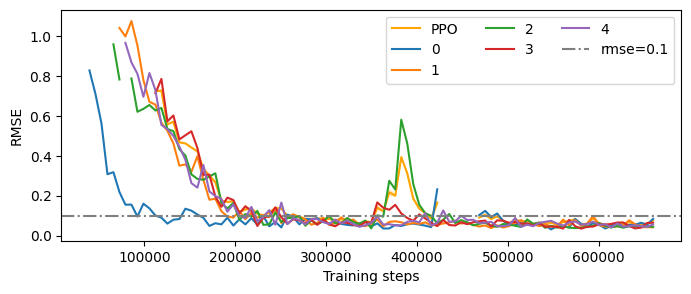

In [ ]:
eval_data = {}
w = 1
fig = plt.figure(figsize=(8, 3))
mean_fn = np.percentile
perc = 90
plot_seeds = True

for t, method in enumerate(data_paths.keys()):
    print(method)
    temp = np.zeros((len(seeds), 6, perf_data[method][seeds[0]]["x"].shape[0]))
    for seed in seeds:
        temp[seed, 0, :] = perf_data[method][seed]["x"]
        temp[seed, 1, :] = perf_data[method][seed]["y"]
        temp[seed, 2, :] = perf_data[method][seed]["z"]
        temp[seed, 3, :] = perf_data[method][seed]["m"]
        temp[seed, 4, :] = perf_data[method][seed]["n"]
        temp[seed, 5, :] = perf_data[method][seed]["l"]
    j_max = 0
    for seed in seeds:
        for j,k in enumerate(temp[seed, 0, :]):
            if temp[seed, 5, j] < 660:
                temp[seed, 1, j] = np.nan
                temp[seed, 2, j] = np.nan
                temp[seed, 3, j] = np.nan
                temp[seed, 4, j] = np.nan
    eval_data.update({method: temp})

    # plot
    plt.plot(temp[0,0,:], mean_fn(temp[:,3,:], perc, axis=0), color=colors[method], label=legends[method])
    plt.fill_between(temp[0,0,:], 
                     np.clip(mean_fn(temp[:,3,:]+w*temp[:,4,:], perc, axis=0), 0, 10),  
                     np.clip(mean_fn(temp[:,3,:]-w*temp[:,4,:], perc, axis=0), 0, 10), color=colors[method], alpha=0.2)
    if plot_seeds:
        for seed in seeds:
            plt.plot(temp[seed,0,:], temp[seed,3,:], label=seed)
            plt.fill_between(temp[0,0,:], 
                             np.clip(temp[seed,3,:]-w*temp[seed,4,:], 0, 10),  
                             np.clip(temp[seed,3,:]+w*temp[seed,4,:], 0, 10), alpha=0.)



# s = 1 # time std
# rmse_ilqr_mean = 0.026000000000000002 * 0
# rmse_ilqr_std = 0.001843908891458577 * 0
plt.axhline(xmin=0.0, xmax=1.95, y=0.1, linestyle='-.', color=colors["iLQR"], label='rmse=0.1')
# plt.fill_between([0.0, last_iter], rmse_ilqr_mean-s*rmse_ilqr_std, rmse_ilqr_mean+s*rmse_ilqr_std, color=colors["iLQR"], alpha=0.25)

# real experiment data
# plt.plot(last_iter, 0.086, color=colors['PPO'], marker='x')
# plt.plot(last_iter, 0.064, color=colors['SAC'], marker='x')

plt.legend(ncol=3)
# plt.ylim(-200,00)
# plt.xlim(right=6e5)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training steps")
plt.ylabel("RMSE")
#plt.title("Task: Quadrotor 2D")
#plt.savefig("performance_logx.pdf",bbox_inches="tight", pad_inches=0.0)

In [ ]:
mean_fn = np.mean
for method in eval_data.keys():
    print(method)
    print(mean_fn(eval_data[method][:, 3, :], axis=0))

PPO
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.26790361 0.22807108 0.18980713 0.16330053 0.13762581
 0.1207609  0.10932789 0.0900497  0.07063229 0.0585894  0.0466095
 0.0460997  0.04961646 0.04840762 0.04278864 0.03734574 0.03677834
 0.03701848 0.03908621 0.03867297 0.0360975  0.03486813 0.04169359
 0.03725969 0.03457009 0.03849986 0.03885277 0.0400471  0.04342527
 0.041256   0.0388206  0.03144821 0.03468308 0.03563006 0.03330509
 0.03826558 0.07731813]
DPPO
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.25586162 0.24190134 0.22537191 0.20194781 0.18302899
 0.17394095 0.15722846 0.13726